In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from os import listdir

In [2]:
# has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

In [ ]:
'''Constants'''
IMAGE_FOLDER = "../data/anime wallpapers"

In [3]:
'''Load data'''
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [4]:
def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)
        
def minibatch_image_generator(image_filenames, batch_size):
    epoch = 0 
    while 1:
        scrambled_images = np.random.permutation([misc.imread(img) for img in image_filenames])
        for batch_number in range(int(np.ceil(len(scrambled_images)/batch_size))):
            start_index = batch_number*batch_size
            end_index = min(len(scrambled_images),start_index+batch_size)
            yield epoch, scrambled_images[start_index:end_index]
        epoch = epoch + 1

In [5]:
gen = minibatch_image_generator(image_jpg_paths,1)

In [6]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride_input = [1, 2, 2, 1]):
  return tf.nn.conv2d(x, W, strides = stride_input, padding='SAME')

In [7]:
small_train = tf.placeholder('float32', shape = [None, 540, 960, 3])
large_train = tf.placeholder('float32', shape = [None, 1080, 1920, 3])

small_train_flattened = tf.reshape(small_train,[-1, 540*960*3])
large_train_flattened = tf.reshape(large_train,[-1, 1080*1920*3])

reshaped_to_image_format = tf.reshape(small_train,[-1,540,960,3])

BATCH_SIZE = 1
n_1 = 32
n_2 = 64
n_3 = 3 #For output image

w_conv1 = weight_variable([2,2,3,n_1]) #7
b_conv1 = bias_variable([n_1])
h_conv1 = tf.nn.relu(conv2d(reshaped_to_image_format, w_conv1, stride_input = [1, 1, 1, 1]) + b_conv1)


w_conv2 = weight_variable([2,2,n_1,n_2]) #7
b_conv2 = bias_variable([n_2])
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, stride_input = [1, 1, 1, 1]) + b_conv2)

resized = tf.image.resize_bilinear(h_conv2, [1080*2, 1920*2])

w_conv3 = weight_variable([8,8,n_2,3]) #7
b_conv3 = bias_variable([3])
h_conv3 = conv2d(resized, w_conv3, stride_input = [1, 2, 2, 1]) + b_conv3

'''
w_conv_inv1 = weight_variable([4,4,n_3,n_2])
h_conv_inv1 = tf.nn.conv2d_transpose(h_conv2, w_conv_inv1, [BATCH_SIZE,1080,1920,n_3], [1,2,2,1])
'''


final = tf.minimum(tf.nn.relu(h_conv3),255)

prediction = tf.reshape(final,[-1,1080*1920*3])

MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))
pred = tf.cast(final, dtype=tf.uint8)
optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [8]:
image_gen = minibatch_image_generator(image_jpg_paths,BATCH_SIZE)

In [9]:
sess = tf.Session()
sess.run(init)

In [10]:

print("generating images") 
epoch,image_batch = next(image_gen)
print("generated images")    
for index in range(10000):
    small_image = np.array([scipy.misc.imresize(img,[540,960]) for img in image_batch])
    (_,mse) = sess.run([optimizer,MSE], feed_dict={small_train:small_image, large_train:image_batch})
    if(index % 1000 == 0):
        print('step = %-5d mse = %-10f' % (index,mse))
        
(sample) = sess.run(pred,feed_dict={small_train:small_image, large_train:image_batch})

generating images
generated images
step = 0     mse = 23407.638672
step = 1000  mse = 88.709900 
step = 2000  mse = 78.730194 
step = 3000  mse = 75.930649 
step = 4000  mse = 70.346176 
step = 5000  mse = 65.734779 
step = 6000  mse = 64.732407 
step = 7000  mse = 67.090073 
step = 8000  mse = 66.368019 
step = 9000  mse = 61.478916 


In [19]:
epoch,image_batch = next(image_gen)
small_image = np.array([scipy.misc.imresize(img,[540,960]) for img in image_batch])

In [17]:
(h_3) = sess.run(h_conv3,feed_dict={small_train:small_image, large_train:image_batch})
h_3.shape

(1, 1080, 1920, 3)

In [11]:
(sample) = sess.run(pred,feed_dict={small_train:small_image})

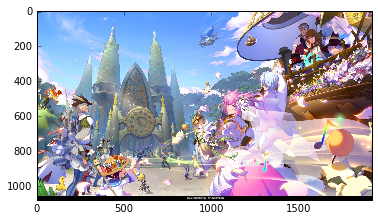

In [12]:
plt.imshow(sample[0])

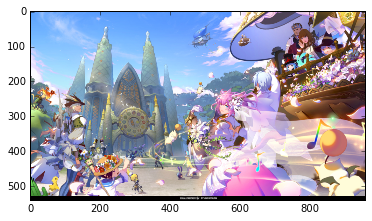

In [13]:
plt.imshow(small_image[0])

In [31]:
rezoomed = misc.imresize(small_image[0],[1080,1920])

In [23]:
misc.imsave("../data/anime wallpapers/generated_output/new_output4.png", sample[0])

In [24]:
misc.imsave("../data/anime wallpapers/generated_output/new_input4.png", small_image[0])

In [25]:
misc.imsave("../data/anime wallpapers/generated_output/new_origional4.png", image_batch[0])